In [2]:
from __future__ import division, print_function, unicode_literals

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
np.random.seed(40)
tf.set_random_seed(40)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

cDim = 14
cDimS = cDim**2

def feedCrop(images,labels):
    croppedImages = images;
    croppedBatch = np.empty(shape=(len(images),cDimS), dtype=np.float64)
    for x in range(len(croppedImages)):
        currentImage = croppedImages[x].reshape(28,28)
        newImage = np.empty(shape=(cDim,cDim),dtype=np.float64);
        
        l = random.randint(5,10)
        w = random.randint(5,10)

        newImage = currentImage[l:l+cDim,w:w+cDim] 
        
        croppedBatch[x] = newImage.reshape(cDimS);
        
    return croppedBatch,labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


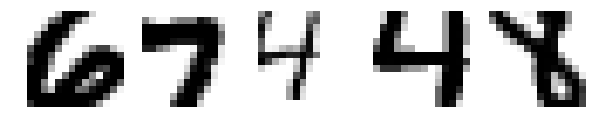

In [3]:
n_samples = 5
batch_size = 5
train1, labels1 = mnist.train.next_batch(batch_size)
train1, labels1 = feedCrop(train1,labels1)

n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = train1[index].reshape(cDim, cDim)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [4]:
#Squashing function ----------------------------------------------

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

#Safe norm function ---------------------------------------------

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

#Architecture:---------------------------------------------------- adapted from hanson-ml extra_capsnets.py

#input layer placeholder
X = tf.placeholder(shape=[None, cDim, cDim, 1], dtype=tf.float32, name="X")

#Convolutional parameters
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 4 * 4  # 1152 primary capsules
caps1_n_dims = 8

#Convolutional layer creation
conv1_params = {
    "filters": 256,
    "kernel_size":3,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu6,
}
conv2_params = {
    "filters": 256,
    "kernel_size":3,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu6,
}
conv3_params = {
    "filters": 256,
    "kernel_size":3,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu6,
}
conv4_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 5,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu6,
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)
conv3 = tf.layers.conv2d(conv2, name="conv3", **conv3_params)
conv4 = tf.layers.conv2d(conv3, name="conv4", **conv4_params)


#reshape of the concolutional layer to the primary capsule dimensions
caps1_raw = tf.reshape(conv4, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")
#Squashes the raw layer from 0 to 1.
caps1_output = squash(caps1_raw, name="caps1_output")

#digit capsule (secondary) layer
caps2_n_caps = 10
caps2_n_dims = 32

init_sigma = 0.1

W_init = tf.truncated_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

#okay.
batch_size = tf.shape(X)[0]

#tiled weights over batch size?
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

#science
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

#gets Uj|i
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")
#Routing ------------------------------------------------------------------
#routing round 1

raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

#squash output
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

#routing round 2
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")

#squash output
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

caps2_output_round_2_tiled = tf.tile(
    caps2_output_round_2, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_2_tiled")

agreement2 = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

#routing round 2
raw_weights_round_3 = tf.add(raw_weights, agreement2,
                             name="raw_weights_round_3")

routing_weights_round_3 = tf.nn.softmax(raw_weights_round_3,
                                        dim=2,
                                        name="routing_weights_round_3")
weighted_predictions_round_3 = tf.multiply(routing_weights_round_3,
                                           caps2_predicted,
                                           name="weighted_predictions_round_3")
weighted_sum_round_3 = tf.reduce_sum(weighted_predictions_round_3,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_3")

#squash output
caps2_output_round_3 = squash(weighted_sum_round_3,
                              axis=-2,
                              name="caps2_output_round_3")

#final output for now.-----------------------------------------------------
caps2_output = caps2_output_round_3


#Loss ---------------------------------------------------------------------

y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

#Reconstruction -----------------------------------------------------------
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")


caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

#Decoder ----------------------------------------------------------------------

n_hidden1 = 1024
n_hidden2 = 2048
n_output = cDim * cDim

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

alpha = 0.0001


#Final loss ----------------------------------------------------------------------
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")


correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead


In [5]:
#Training ------------------------------------------------------------------------
n_epochs = 25
batch_size = 100
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./CMnistCaps_14x14_feedCrop_A12"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    lossFail = 0;
    for epoch in range(0,n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch, y_batch = feedCrop(X_batch,y_batch)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, cDim, cDim, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            X_batch, y_batch = feedCrop(X_batch,y_batch)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, cDim, cDim, 1]),
                               y: y_batch})
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val
            lossFail = 0;
        else:
            lossFail += 1;
            if(lossFail == 5):
                break;


Epoch: 1  Val accuracy: 91.0400%  Loss: 0.083914 (improved)
Epoch: 2  Val accuracy: 93.8600%  Loss: 0.055127 (improved)
Epoch: 3  Val accuracy: 94.0000%  Loss: 0.051254 (improved)
Epoch: 4  Val accuracy: 94.8400%  Loss: 0.044770 (improved)
Epoch: 5  Val accuracy: 95.0600%  Loss: 0.042936 (improved)
Epoch: 6  Val accuracy: 95.8800%  Loss: 0.036859 (improved)
Epoch: 7  Val accuracy: 95.4200%  Loss: 0.040274
Epoch: 8  Val accuracy: 95.4600%  Loss: 0.038661
Epoch: 9  Val accuracy: 95.9600%  Loss: 0.035350 (improved)
Epoch: 10  Val accuracy: 96.1600%  Loss: 0.034062 (improved)
Epoch: 11  Val accuracy: 95.7200%  Loss: 0.034898
Epoch: 12  Val accuracy: 96.2000%  Loss: 0.033985 (improved)
Epoch: 13  Val accuracy: 96.3600%  Loss: 0.032761 (improved)
Epoch: 14  Val accuracy: 95.7200%  Loss: 0.033194
Epoch: 15  Val accuracy: 96.2400%  Loss: 0.032724 (improved)
Epoch: 16  Val accuracy: 96.1600%  Loss: 0.032141 (improved)
Epoch: 17  Val accuracy: 96.2600%  Loss: 0.031817 (improved)
Epoch: 18  Val a

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    lossFail = 0;
    for epoch in range(25,51):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch, y_batch = feedCrop(X_batch,y_batch)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, cDim, cDim, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            X_batch, y_batch = feedCrop(X_batch,y_batch)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, cDim, cDim, 1]),
                               y: y_batch})
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val
            lossFail = 0;
        else:
            lossFail += 1;
            if(lossFail == 5):
                break;


INFO:tensorflow:Restoring parameters from ./CMnistCaps_14x14_feedCrop_A12
Epoch: 26  Val accuracy: 96.3200%  Loss: 0.029455
Epoch: 27  Val accuracy: 95.9600%  Loss: 0.031700
Epoch: 28  Val accuracy: 96.6800%  Loss: 0.027941 (improved)
Epoch: 29  Val accuracy: 96.4600%  Loss: 0.029311
Epoch: 30  Val accuracy: 96.9000%  Loss: 0.025053 (improved)
Epoch: 31  Val accuracy: 96.4400%  Loss: 0.030185
Epoch: 32  Val accuracy: 96.5200%  Loss: 0.028051
Epoch: 33  Val accuracy: 96.6000%  Loss: 0.028287
Epoch: 34  Val accuracy: 96.7000%  Loss: 0.027792
Iteration: 453/550 (82.4%)  Loss: 0.00976

In [9]:
n_iterations_test = mnist.test.num_examples // batch_size
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, checkpoint_path)
    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        X_batch, y_batch = feedCrop(X_batch,y_batch)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, cDim, cDim, 1]),
                           y: y_batch})
        
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./CMnistCaps_14x14_feedCrop_A12
Final test accuracy: 96.2500%  Loss: 0.030448   


INFO:tensorflow:Restoring parameters from ./CMnistCaps_14x14_feedCrop_A12


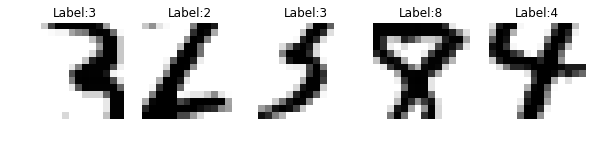

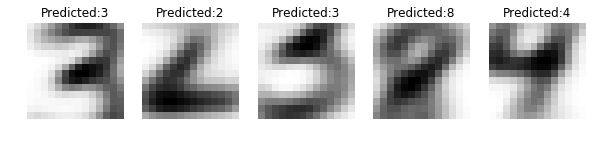

In [7]:
n_samples = 5
labs = np.empty(shape = (n_samples))

sample_images, labs = feedCrop(mnist.test.images[:n_samples],labs)
sample_images = sample_images.reshape([-1, cDim, cDim, 1])

with tf.Session(config=config) as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

sample_images = sample_images.reshape(-1, cDim, cDim)
reconstructions = decoder_output_value.reshape([-1, cDim, cDim])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


In [12]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
        
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
   
    total_parameters += variable_parameters
print(total_parameters)

6961604
